<a href="https://colab.research.google.com/github/zeyad-mohvme-d/-Sign-Language-Fingerspelling-Assistant-ASL-Alphabet-/blob/main/ASL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
import os

In [5]:
import kagglehub

path = kagglehub.dataset_download("grassknoted/asl-alphabet")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'asl-alphabet' dataset.
Path to dataset files: /kaggle/input/asl-alphabet


In [7]:
path = "/kaggle/input/asl-alphabet"

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(path, "asl_alphabet_train/asl_alphabet_train"),
    validation_split = 0.1,
    subset = "training",
    seed = 123,
    shuffle = True,
    image_size = (128, 128),
    batch_size = 32
)


val_data = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(path, "asl_alphabet_train", "asl_alphabet_train"),
    validation_split=0.1,
    subset="validation",
    seed=123,
    shuffle = True,
    image_size=(128, 128),
    batch_size=32

)

Found 87000 files belonging to 29 classes.
Using 78300 files for training.
Found 87000 files belonging to 29 classes.
Using 8700 files for validation.


In [8]:
type(train_data)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [9]:
len(train_data)

2447

In [10]:
clas_names = train_data.class_names
clas_names

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

In [11]:
m = {}

for i in range(26):
    m[chr(ord('A') + i)] = i

m["nothing"] = 27
m["space"] = 28

In [12]:
test_data = []
test_labels = []

test_path = os.path.join(path, "asl_alphabet_test", "asl_alphabet_test")
image_size = (128, 128)


for filename in os.listdir(test_path):
  img_path = os.path.join(test_path, filename)
  char = filename.split("_")[0]
  test_labels.append(m[char])
  img = load_img(img_path, target_size=image_size)
  img_array = img_to_array(img)
  test_data.append(img_array)

# m{'A'} = 0

print(test_data[0].shape)
print(test_labels)


test_data = np.array(test_data)
test_labels = np.array(test_labels)




(128, 128, 3)
[0, 4, 11, 13, 18, 3, 6, 8, 22, 12, 27, 23, 7, 16, 2, 19, 15, 21, 24, 20, 28, 14, 1, 17, 5, 25, 9, 10]


In [13]:
images, labels = next(iter(train_data))

images = images.numpy()
labels = labels.numpy()


In [14]:
from tensorflow.keras.layers import RandomRotation, RandomBrightness, RandomZoom, RandomContrast, Rescaling



data_Augmentation  = tf.keras.Sequential([
    Rescaling(1./255),
    RandomRotation(0.2),
    RandomZoom(0.2),
])

In [15]:
aug = data_Augmentation(images)

type(aug)

tensorflow.python.framework.ops.EagerTensor

In [16]:
print(type(images))      # هل NumPy array ولا Tensor؟
print(images.dtype)      # float32, uint8, إلخ
print(images.shape)      # شكل الصور (batch, height, width, channels)
print(np.min(images), np.max(images))

<class 'numpy.ndarray'>
float32
(32, 128, 128, 3)
0.0 255.0


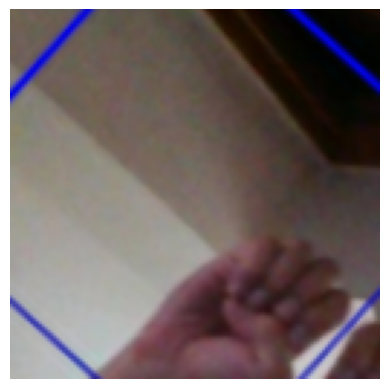

In [17]:
plt.imshow(aug[4])
plt.axis('off')
plt.show()

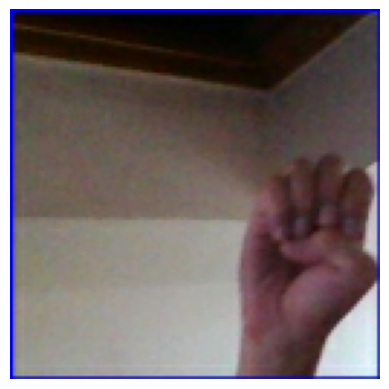

In [18]:
images = images / 255.0

plt.imshow(images[4])
plt.axis('off')
plt.show()

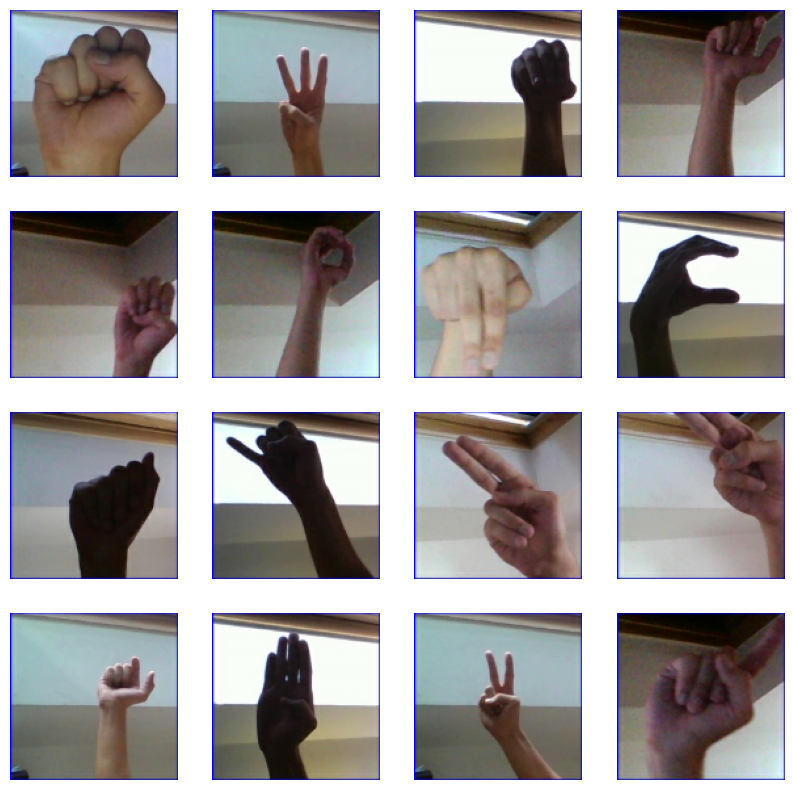

In [19]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i in range(4):
    for j in range(4):
        idx = i*4 + j
        axes[i, j].imshow(images[idx])
        axes[i, j].axis('off')

plt.show()

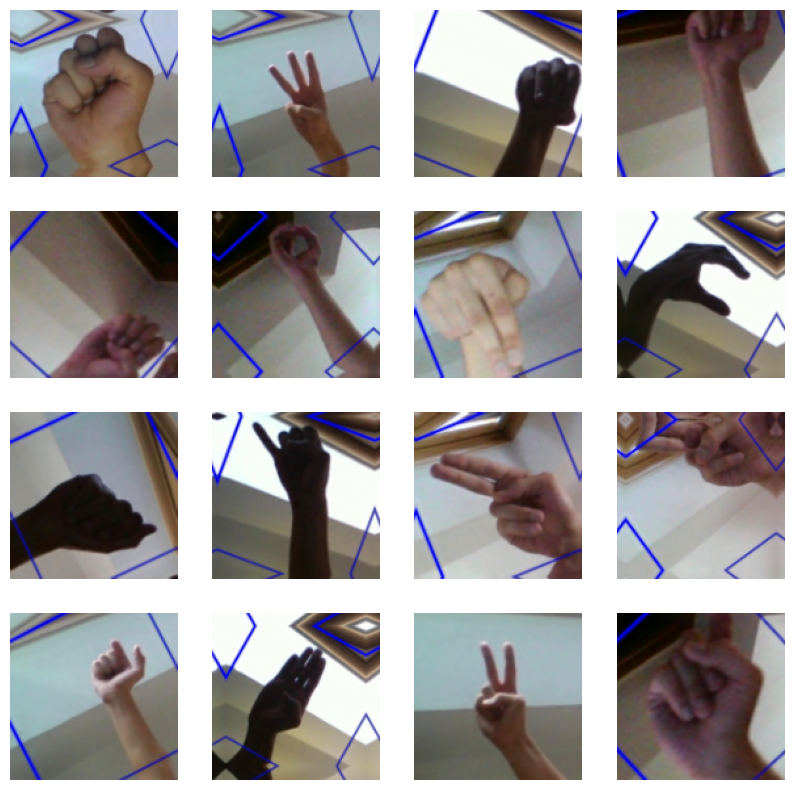

In [20]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i in range(4):
    for j in range(4):
        idx = i*4 + j
        axes[i, j].imshow(aug[idx])
        axes[i, j].axis('off')

plt.show()

In [21]:
from tensorflow.keras.layers import Conv2D, Dropout, Input, GlobalAveragePooling2D, Dense, BatchNormalization, MaxPool2D, Rescaling, RandomRotation, RandomZoom, Flatten
NUMBER_OF_CLASSES = 29

model = tf.keras.models.Sequential([
    Input((128, 128, 3)),

    Rescaling(1./255),
    RandomRotation(0.2),
    RandomZoom(0.2),

    Conv2D(64, (3, 3), padding="same", activation="relu"),
    # Dropout(0.2),
    MaxPool2D(),

    Conv2D(64, (3, 3), padding='same', activation="relu"),
    # Dropout(0.3),
    MaxPool2D(),

    Conv2D(128, (3, 3), padding='same', activation="relu"),
    Dropout(0.3),
    MaxPool2D(),

    Flatten(), # Replaced GlobalAveragePooling2D with Flatten
    # Dropout(0.3), # This dropout can be uncommented if desired after pooling
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(NUMBER_OF_CLASSES, activation="softmax")
])




# model = tf.keras.Sequential([

#     # -------------------------------
#     # 🔹 Input + Normalization + Augmentation
#     # -------------------------------
#     Input((128, 128, 3)),
#     Rescaling(1./255),
#     RandomRotation(0.15),
#     RandomZoom(0.15),

#     # -------------------------------
#     # 🔹 Convolution Block 1
#     # -------------------------------
#     Conv2D(64, (3, 3), padding="same", activation="relu"),
#     MaxPool2D(),

#     # -------------------------------
#     # 🔹 Convolution Block 2
#     # -------------------------------
#     Conv2D(128, (3, 3), padding="same", activation="relu"),
#     MaxPool2D(),

#     # -------------------------------
#     # 🔹 Convolution Block 3
#     # -------------------------------
#     Conv2D(256, (3, 3), padding="same", activation="relu"),
#     MaxPool2D(),
#     Dropout(0.3),

#     # -------------------------------
#     # 🔹 Feature Aggregation
#     # -------------------------------
#     Flatten(),

#     # -------------------------------
#     # 🔹 Dense Classifier
#     # -------------------------------
#     Dense(128, activation="relu"),
#     Dropout(0.3),
#     Dense(64, activation="relu"),

#     # -------------------------------
#     # 🔹 Output Layer
#     # -------------------------------
#     Dense(NUMBER_OF_CLASSES, activation="softmax")
# ])

In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])

In [23]:
history = model.fit(train_data,batch_size=32, epochs=30, validation_data=val_data, callbacks=[early_stopping])

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2447/2447 ━━━━━━━━━━━━━━━━━━━━ 115s 44ms/step - accuracy: 0.1364 - loss: 2.9614 - val_accuracy: 0.5426 - val_loss: 1.3293
Epoch 2/30
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 102s 42ms/step - accuracy: 0.6053 - loss: 1.1591 - val_accuracy: 0.7293 - val_loss: 0.7469
Epoch 3/30
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 142s 41ms/step - accuracy: 0.7647 - loss: 0.6701 - val_accuracy: 0.8580 - val_loss: 0.4160
Epoch 4/30
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 142s 41ms/step - accuracy: 0.8275 - loss: 0.4911 - val_accuracy: 0.8872 - val_loss: 0.3261
Epoch 5/30
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 102s 42ms/step - accuracy: 0.8592 - loss: 0.3953 - val_accuracy: 0.8862 - val_loss: 0.3075
Epoch 6/30
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 99s 40ms/step - accuracy: 0.8847 - loss: 0.3267 - val_accuracy: 0.9203 - val_loss: 0.2182
Epoch 7/30
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 100s 41ms/step - accuracy: 0.9008 - loss: 0.2842 - val_accuracy: 0.9138 - val_loss: 0.2422
Epoch 8/30
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 100s 41ms/step - accuracy: 0.9104 - los

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

In [24]:
model.save("CNN_model.h5")


In [25]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# ===========================
# 1. Load Dataset
# ===========================

IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
NUMBER_OF_CLASSES = 29



# ===========================
# 3. Load EfficientNetB0
# ===========================

base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(128, 128, 3)
)

base_model.trainable = False  # Freeze weights

# ===========================
# 4. Build Final Model
# ===========================

inputs = tf.keras.Input(shape=(128, 128, 3))

data_Augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

inputs = tf.keras.Input(shape=(128, 128, 3))

x = data_Augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)

x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)

x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)

outputs = Dense(NUMBER_OF_CLASSES, activation="softmax")(x)

modelEff = Model(inputs, outputs)

# ===========================
# 5. Compile
# ===========================

modelEff.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

modelEff.summary()

# ===========================
# 6. Early Stopping
# ===========================

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# ===========================
# 7. Train
# ===========================

history = modelEff.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks=[early_stopping]
)

# ===========================
# 8. Evaluate
# ===========================

loss, acc = modelEff.evaluate(val_data)
print("Validation Accuracy:", acc)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 29)             │         7,453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,384,960 (16.73 MB)

 Trainable params: 335,389 (1.28 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/30
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 107s 39ms/step - accuracy: 0.6046 - loss: 1.3394 - val_accuracy: 0.8864 - val_loss: 0.3547
Epoch 2/30
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 96s 39ms/step - accuracy: 0.8386 - loss: 0.4940 - val_accuracy: 0.9111 - val_loss: 0.2576
Epoch 3/30
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 142s 39ms/step - accuracy: 0.8725 - loss: 0.3897 - val_accuracy: 0.9101 - val_loss: 0.2650
Epoch 4/30
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 96s 39ms/step - accuracy: 0.8891 - loss: 0.3361 - val_accuracy: 0.9356 - val_loss: 0.1868
Epoch 5/30
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 95s 39ms/step - accuracy: 0.8952 - loss: 0.3142 - val_accuracy: 0.9454 - val_loss: 0.1694
Epoch 6/30
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 94s 39ms/step - accuracy: 0.9040 - loss: 0.2854 - val_accuracy: 0.9471 - val_loss: 0.1534
Epoch 7/30
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 95s 39ms/step - accuracy: 0.9119 - loss: 0.2686 - val_accuracy: 0.9526 - val_loss: 0.1440
Epoch 8/30
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 143s 39ms/step - accuracy: 0.913

In [26]:
modelEff.save("EfficientNetB0_model.h5")